# An Image Classifer in Pytorch

In this project, we will train an image classifier to recognize different species of flowers. This could be used as part of a smartphone app, or part of a research project to automatically sift through and label a vast number of images from a field season. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories.


The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

This project demonstrates skills necessary to devloping an application that can be trained on any set of labeled images. We could in theory use this code to embed an image classifier into any application that can be trained on labeled image data. This Notebook shows the necessary steps to process the data and make predictions, which we will then use to make a command line application.

In [2]:
# Imports here
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np

from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

import json

from PIL import Image

## Load the data
The networks that we will use for transfer learning were trained on the ImageNet dataset. Each color channel was standardized differently, with means and standard deviations of `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]` respectively. We'll need to include that in the transforms that we perform on all of the training, validation, and testing data sets. For the training set, we can apply randomized rotations and flips to try and force the model to learn from varied input.

In [4]:
#specify data directories
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [5]:
#define transforms for the training, validation, and testing sets
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomVerticalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

#validation transforms
val_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

#test transforms
test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])])

#load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(valid_dir, transform=val_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

#using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

In [10]:
print('The length of the training set is {}.'.format(len(train_data)))
print('The length of the validation set is {}.'.format(len(val_data)))
print('The length of the testing set is {}.'.format(len(test_data)))

The length of the training set is 6552.
The length of the validation set is 818.
The length of the testing set is 819.


### Label mapping

Here, we can create a dictionary of categories to label names. This will be useful later on when we want to give names to our class predictions.

In [11]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [12]:
print('We have {} classes in our dataset.'.format(len(cat_to_name)))

We have 102 classes in our dataset.


As the dataset staes, there are 102 unique types of flowers in the dataset. So our network should have 102 output units.

# Building and training the classifier

We are going to do some transfer learning! As stated above, we are going to speed up our development cycle by using a pre-trained network. We can use VGG16 for example, freeze its weights, and then replace just the classfiier to match the number of classes that we have in our project (in this case 102).

In [15]:
#load in vgg16 from torch.models
model = models.vgg16(pretrained=True)

Because our model is already trained, we can freeze the any current parameters that the features have and turn backpropagation off. Additionally, we can re-define the "classifier" part of the model for our specific uses. We need to match the number of input features of 25088, but then we can scale down to 102 output features (not 1000 as is currently the case) as stipulated above.

In [16]:
#set model to run on gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#because our model is already pretrained, we don't want to change theh weights
#turn back propagation off
for parameter in model.parameters():
    parameter.requires_grad = False
    
#define our own classifier
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 1024)),
    ('relu1', nn.ReLU()),
    ('drop1', nn.Dropout(0.2)),
    
    ('fc2', nn.Linear(1024, 512)),
    ('relu2', nn.ReLU()),
    ('drop2', nn.Dropout(0.2)),

    
    ('fc3', nn.Linear(512, 102)),
    ('output', nn.LogSoftmax(dim=1))
    ]))

#set the pretrained network's classifier to our newly created one
model.classifier = classifier

#define loss metric and optimizer
criterion = nn.NLLLoss()

#update parameters for classifier, not features
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

#change to gpu
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Above, we can see VGG16's architecture. It now includes our custom-made classifier, and is ready to be trained on our data.

In [9]:
#training
epochs = 5
steps = 0
running_loss = 0
print_every = 60

#lists for saving loss, will be used for plotting later
train_losses, val_losses, acc = [], [], []

for epoch in range(epochs):
    for images, labels in trainloader:
        steps += 1
        
        #convert FloatTensors to cudaTensors to run on gpu
        images, labels = images.to(device), labels.to(device)
        
        #return gradient to zero for new computation
        optimizer.zero_grad()
        
        #forward propagation, calculate log probabilities
        logps = model.forward(images)
        
        #compute loss for model, labels
        loss = criterion(logps, labels)
        
        #backprop
        loss.backward()
        
        #gradient step
        optimizer.step()
        
        #now append loss
        running_loss += loss.item()
        
        #validation step
        if steps % print_every == 0:
            val_loss = 0
            accuracy = 0
            model.eval()
            
            with torch.no_grad():
                for images, labels in validloader:
                    
                    images, labels = images.to(device), labels.to(device)
                    
                    logps = model.forward(images)
                    batch_loss = criterion(logps, labels)
                    val_loss += batch_loss.item()
                    
                    probs = torch.exp(logps)
                    top_prob,top_label = probs.topk(1, dim=1)
                    
                    equality = top_label == labels.view(*top_label.shape)
                    
                    accuracy += torch.mean(equality.type(torch.cuda.FloatTensor)).item()
                
                print("{}/{}:  ".format(epoch+1, epochs),
                    "Training_loss: {:.3f}".format(running_loss/print_every),
                    "Validation loss: {:.3f}".format(val_loss/len(validloader)),
                    "Validation Accuracy: {:.3f}".format(accuracy/len(validloader)))
                
                #append calculated losses from each epoch
                train_losses.append(running_loss / print_every)
                val_losses.append(val_loss / len(validloader))
                acc.append(accuracy / len(validloader))
                
                #turn training back on at the end of validation loop
                running_loss = 0
                model.train()

1/5:   Training_loss: 3.917 Validation loss: 2.583 Validation Accuracy: 0.402
1/5:   Training_loss: 2.554 Validation loss: 1.584 Validation Accuracy: 0.555
1/5:   Training_loss: 2.068 Validation loss: 1.288 Validation Accuracy: 0.658
2/5:   Training_loss: 1.753 Validation loss: 1.157 Validation Accuracy: 0.699
2/5:   Training_loss: 1.591 Validation loss: 1.070 Validation Accuracy: 0.698
2/5:   Training_loss: 1.454 Validation loss: 0.946 Validation Accuracy: 0.747
3/5:   Training_loss: 1.424 Validation loss: 0.876 Validation Accuracy: 0.771
3/5:   Training_loss: 1.342 Validation loss: 0.798 Validation Accuracy: 0.789
3/5:   Training_loss: 1.325 Validation loss: 0.742 Validation Accuracy: 0.807
3/5:   Training_loss: 1.224 Validation loss: 0.774 Validation Accuracy: 0.783
4/5:   Training_loss: 1.198 Validation loss: 0.800 Validation Accuracy: 0.791
4/5:   Training_loss: 1.201 Validation loss: 0.822 Validation Accuracy: 0.778
4/5:   Training_loss: 1.180 Validation loss: 0.718 Validation Ac

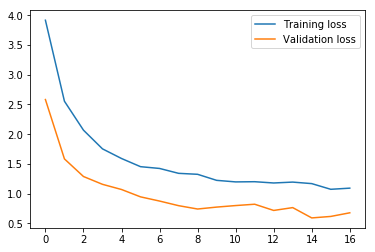

In [10]:
#plot training and validation losses
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()

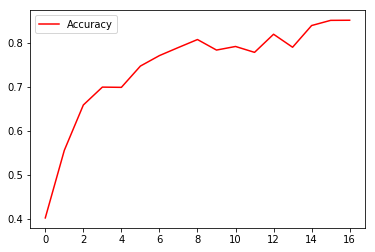

In [11]:
plt.plot(acc, color='r', label='Accuracy')
plt.legend()

As you can see, both the training and validation loss are decreasing. Our model is doing a good job of learning the validation set without overfitting on the training set. Additionally, we have achieved an accuracy of 83% in just 5 epochs! If we are satistified with our model, we can test on the test set which it has not seen before.

## Testing set

Now that our model is trained, we need to test it on data that it has never seen before. Let's see how it does.

In [24]:
# TODO: Do validation on the test set
test_losses = []
test_loss = 0
accuracy = 0
    
#do not evaluate while computing gradients
with torch.no_grad():
    model.eval()
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        log_probs = model.forward(images)
                
        loss = criterion(log_probs, labels)
        test_loss += loss
                
        #convert from log probabilites to probabilities
        probs = torch.exp(log_probs)
                
        #take the top class probability
        top_prop, top_class = probs.topk(1, dim=1)
                
        #update accuracy
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
test_losses.append(test_loss/len(testloader))

print("Testing Loss: {:.3f}.. ".format(running_loss/len(testloader)),
        "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Testing Loss: 0.204..  Test Accuracy: 0.814


Not bad! We get about the same accuracy as we did on our training and validation data. Obviously, if we pushed our model to 10 or 20 epochs, we could get well over 90-95% accuracy. However, this notebook is just for demonstration purposes. Feel free to use `train.py` and `predict.py` included in this repository and change the hyperparameters to see how well you can do!

## Save the checkpoint

Now that we have trained our network, we need to save it so that we can load it later. PyTorch makes this really easy. We simply specify the features that we would like to save as a dictionary, and specify a filename for where we would like to save it.

In [25]:
# TODO: Save the checkpoint 
checkpoint = {'epochs': epochs,
              'optim': optimizer.state_dict,
              'train_idx': train_data.class_to_idx,
              'val_idx': val_data.class_to_idx,
              'test_idx': test_data.class_to_idx,
              'state_dict': model.state_dict(),
              'architecture': 'vgg16'
             }

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

Now we can write a function that loads the model based on a `state_dict` parameter that we saved from before. This allows us to fully reconstruct the model that we used before.

In [26]:
#helper function that loads a checkpoint and rebuilds the model
def load_model(filename):
    #load checkpoint
    checkpoint = torch.load(filename)
    
    #load model architecture
    model.load_state_dict(checkpoint['state_dict'])
    
    #create dictionary of other saved keys
    hyperparameters = checkpoint
    del hyperparameters['state_dict']
    
    return hyperparameters, model

## Image Preprocessing, Plotting, and Predicting

Below are three methods that I wrote to process and image, make predictions on that image, and then plot it with a given number of top classes and their respective probabilities.

To process the image, we need to make sure that the image is of the correct size, and is center cropped. This method assumes that the images are of at least the dimensions (224, 224). It then standardizes the color channels just like we did in defining our transforms at the beginning of this Notebook. We then have to permute the axes of the image because PyTorch and Matplotlib assume different axes locations.

In [27]:
#given an image, preprocess it so that we can test on our classifier
def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    #load in image
    pil_image = Image.open(image_path)
    
    #resize
    if pil_image.size[1] > pil_image.size[0]:
        pil_image.thumbnail((256, 9999))
    else:
        pil_image.thumbnail((9999, 256))
    
    #recalculate width and height
    width = pil_image.width
    height = pil_image.height
    
    #calculate cropping points
    to_crop = 224
    
    left = int((width - to_crop) / 2)
    bottom = int((height - to_crop) / 2)
    
    right = left + 224
    top = bottom + 224
    
    #crop the image
    cropped = pil_image.crop((left, bottom, right, top))
    
    #scale color channels
    np_image = np.array(cropped)
    np_image = np.array(np_image)
    np_image = np_image / 255
    
    #normalize and standardize images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image_norm = np_image - mean
    image_std = image_norm / std
    
    #reorder image dimensions
    ready_image = np.transpose(image_std, (2, 0, 1))
    
    return ready_image

In [28]:
#helper method to show the image input by user
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.transpose(image, (1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    if title==None:
        ax.set_title('')
    else:
        ax.set_title(title)
    
    return ax

In [29]:
"""
This method calls the above method, and plots a user's image with the
top classes and their respective probabilities.
"""
#helper function for plotting image and predictions together
def plot(path, title, names, top_probs):
    fig = plt.figure(figsize=(4, 8))

    ax = fig.add_subplot(2, 1, 1)

    #turn off image axis labels
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    #plot the actual image
    imshow(process_image(path), ax=ax, title=title)

    #add second figure, show probabilities with class labels
    ax2 = fig.add_subplot(2, 1 , 2)
    ax2.barh(names, top_probs)
    plt.show()

To predict our classes, we need to specify an image path. We then process the image using our `process_image()` method shown above. Now that we have a processed image, we can make a prediction by running it through a loop similar to the one shown for the testing data. This time, however, the user can input more than one top class.


In [30]:
#helper function that makes predictions on "topk" number of classes
def predict(image_path, model, device, topk):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    #process image
    image = process_image(image_path)
    
    with torch.no_grad():
        model.eval()
        model.to(device)
        
        #convert to cuda tensor, because we are working on the gpu
        image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    
        #inserts a singleton dimension in dim=0, essentially makes a tensor
        image = image.unsqueeze(0) 
    
        #calculate log probabilities
        log_probs = model.forward(image)
                
        #convert from log probabilites to probabilities
        probs = torch.exp(log_probs)
                
        #take the top class probability
        top_probs, top_classes = probs.topk(topk, dim=1)
    
        #return tensors to the cpu so that we can manipulate them
        #then return numpy array versions of those tensors
        top_probs, top_classes = top_probs[0].cpu().numpy(), top_classes[0].cpu().numpy()

        
        return top_probs, top_classes

### Let's see how we do!

Now we can test the methods that we wrote above by giving the `predict()` method a filename and a number of classes for plotting purposes. Additionally, we can allow the user to train on a CPU or a GPU, but for the purposes of the Notebook I stayed with the GPU. If you'd like to see how that could be done, please look at the command line application that I built where this is implemented.

In [31]:
#display an image along with the top 5 classes
#water lily class
path = train_dir+'/73/image_00263.jpg'

#now let's load our model, and then make/visualize our predictions
hyperparams, model = load_model('checkpoint.pth')

top_probs, top_classes = predict(path, model, device, 5)

#read in class labels and indices
train_idx = hyperparams['train_idx']
        
#we need to switch indices and class class labels dictionary
#so that we can look up our top class predictions
idx_to_class = { v : k for k,v in train_idx.items()}

#now convert indices to class labels
top_classes = [idx_to_class[idx] for idx in top_classes]

In [34]:
#get the name of the top flower predicted
idx = np.argmax(top_probs)
flower_name = cat_to_name[top_classes[idx]]
print(flower_name)

water lily


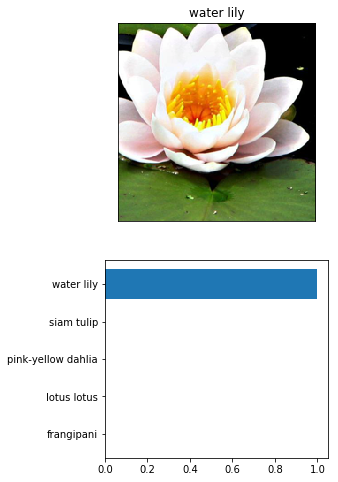

In [35]:
#get names from top classes
names = [cat_to_name[idx] for idx in top_classes]

#plot image and predictions
plot(path, flower_name, names, top_probs)

Let's try again!

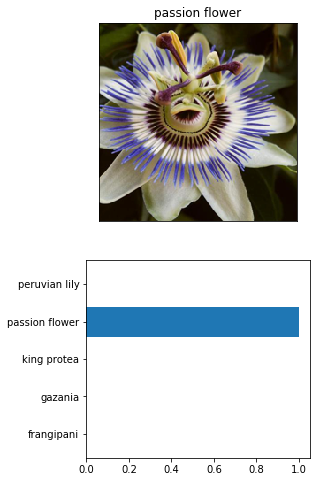

In [36]:
#passion flower
path2 = train_dir+'/77/image_00030.jpg'

top_probs, top_classes = predict(path2, model, device, 5)

top_classes = [idx_to_class[idx] for idx in top_classes]

idx = np.argmax(top_probs)
flower_name2 = cat_to_name[top_classes[idx]]

names = [cat_to_name[idx] for idx in top_classes]

plot(path2, flower_name2, names, top_probs)

Our model is pretty good! After only five epochs of training, we are able to predict different varieties of flowers with high accuracy and confidence. Some flowers do better than others, as well as some images of the same flower do better than others. For now, though, head over to `train.py` and `predict.py` to see how we could embed this model into a software development project.